<a href="https://colab.research.google.com/github/Hercroce/completechowtest/blob/cleaning_control/example/Example_Comprehensive_Chow_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Summary: Comprehensive Chow Test**

The example below employs the Chow Test on monthly data from the last 23 years of Brazilian Foreign Direct Investment (FDI) and Real Exchange Rate (RER) using a window technique. It allows us to analyze the consistency of OLS estimators across every possible data subset and observe differences in results when handling different time spans.

Please see below two examples and the generating code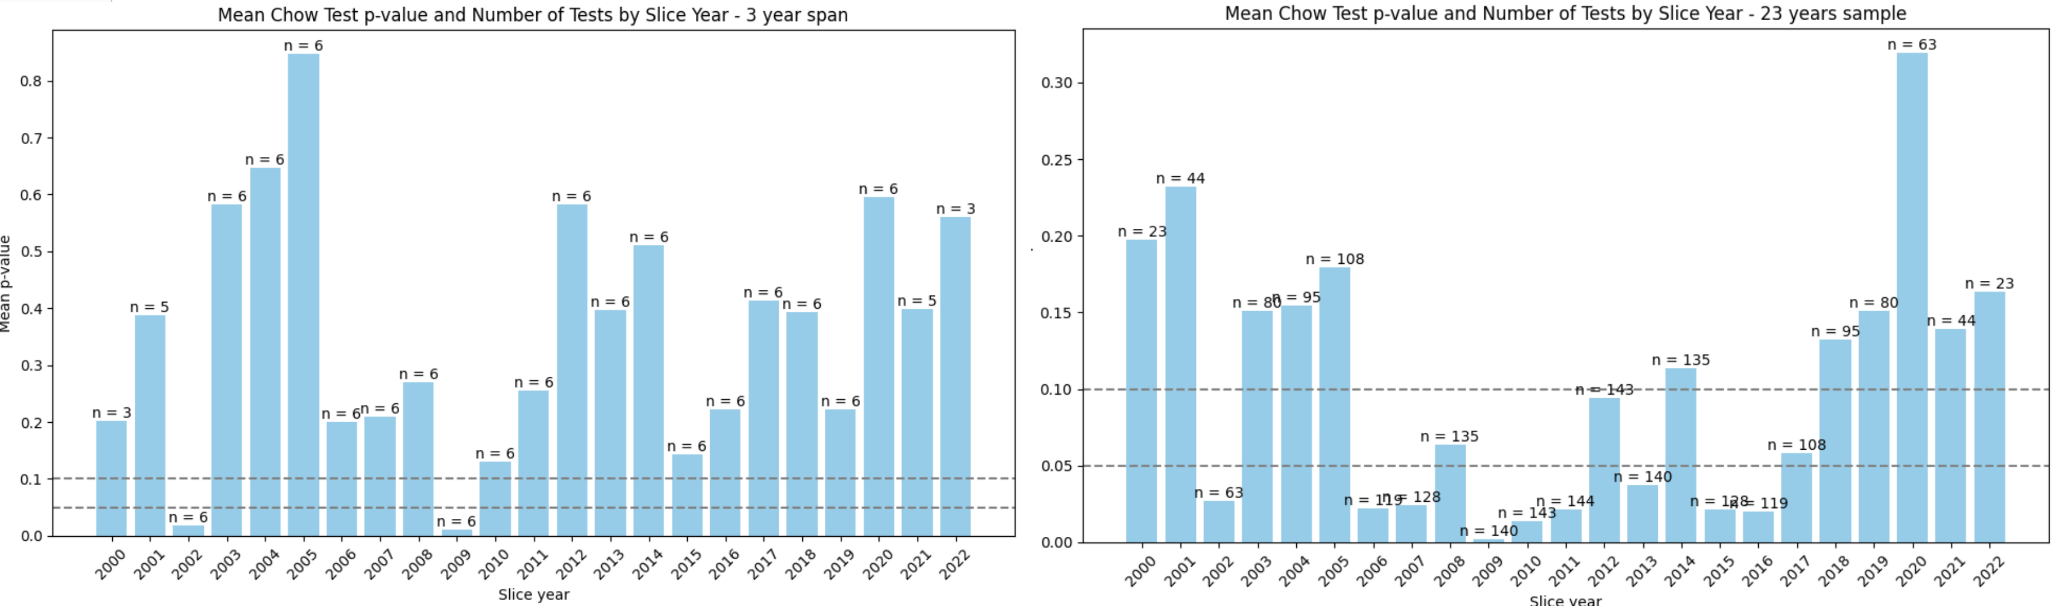


# **Packages**
> import and install all the packages required for our project

In [1]:
import os
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression as lr
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# **Functions**

> Define the functions that will be used on our analyzes, more information can be found on the docstring of each.

In [2]:
def adfuller_test(series, series_name, print_results=False):
  """Returns a dictionary with 'adf_statistic' and 'adf_p_value'"""
  adf_results = adfuller(series)
  if print_results == True:
    print(f'Dickey-Fuller Test Summary for {series_name}')
    print('ADF Statistic: %f' % adf_results[0])
    print('p-value: %f' % adf_results[1])
    print('Critical Values:')
    for key, value in adf_results[4].items():
      print('\t%s: %.3f' % (key, value))

  return {'adf_statistic': adf_results[0], 'adf_p_value':adf_results[1]}


def datetime_month_references(year):
    """Receive an int year and return a dict with equivalent
    pandas datetime string for the first month, last month and first
    month of the next year"""
    reference_dictionare = {}
    reference_dictionare["last_month"] = f'{year}-12-01 00:00:00'
    reference_dictionare["first_month"] = f'{year}-01-01 00:00:00'
    reference_dictionare["next_year_january"] = f'{year + 1}-01-01 00:00:00'
    return reference_dictionare

def year_index(df, date_column, year_column=None):
    """Receive a pandas DataFrame and return a dict of usefull indexes related
    to year and month

    Keyword arguments:
    df -- pandas DataFrame
    date_column -- string name of the date column.
    """
    year_reference_dict = {}

    if year_column != None:
      years = df[year_column].unique().astype(int)
      year_reference_dict["years"] = years

    year_reference_dict["indexes"] = {}
    year_reference_dict["indexes"]["last_months"] = {}
    year_reference_dict["indexes"]["first_months"] = {}
    year_reference_dict["indexes"]["next_months"] = {}

    for year in years:

      last_month = datetime_month_references(year)["last_month"]
      lastmonth_index = df[df[date_column] == last_month].index[0]

      first_month = datetime_month_references(year)["first_month"]
      firstmonth_index = df[df[date_column] == first_month].index[0]


      year_reference_dict["indexes"]["last_months"][f'{year}'] = lastmonth_index
      year_reference_dict["indexes"]["first_months"][f'{year}'] = firstmonth_index
      year_reference_dict["indexes"]["next_months"][f'{year}'] = lastmonth_index + 1

    return year_reference_dict

# **Chow Test function**
> An adapted version of the work developed b @jkcle

In [3]:
"""
This function is an adapted version of the work developed by:
@jkcle
"""

# defines a function to get performance information about a linear regression
# using sklearn
# An alfa coeficient could be included here
def linear_residuals(X, y):

    # fits the linear model
    model = lr().fit(X, y)

    # creates a dataframe with the predicted y in a column called y_hat
    summary_result = pd.DataFrame(columns=['y_hat'])
    yhat_list = [float(i[0]) for i in np.ndarray.tolist(model.predict(X))]
    summary_result['y_hat'] = yhat_list
    # saves the actual y values in the y_actual column
    summary_result['y_actual'] = y.values
    # calculates the residuals
    summary_result['residuals'] = summary_result.y_actual - summary_result.y_hat
    # squares the residuals
    summary_result['residuals_sq'] = summary_result.residuals ** 2

    return (summary_result)


# defines a function to return the sum of squares of a linear regression, where X is a
# pandas dataframe of the independent variables and y is a pandas dataframe of the dependent
# variable
def calculate_RSS(X, y):
    # calls the linear_residual function
    resid_data = linear_residuals(X, y)
    # calculates the sum of squared resiudals
    rss = resid_data.residuals_sq.sum()

    # returns the sum of squared residuals
    return (rss)


# defines a function to return the p-value from a Chow Test
def ChowTest(X, y, last_index_in_model_1, first_index_in_model_2):
    # gets the RSS for the entire period
    rss_pooled = calculate_RSS(X, y)

    # splits the X and y dataframes and gets the rows from the first row in the dataframe
    # to the last row in the model 1 testing period and then calculates the RSS
    X1 = X.loc[:last_index_in_model_1]
    y1 = y.loc[:last_index_in_model_1]
    rss1 = calculate_RSS(X1, y1)

    # splits the X and y dataframes and gets the rows from the first row in the model 2
    # testing period to the last row in the dataframe and then calculates the RSS
    X2 = X.loc[first_index_in_model_2:]
    y2 = y.loc[first_index_in_model_2:]
    rss2 = calculate_RSS(X2, y2)

    # gets the number of independent variables, plus 1 for the constant in the regression
    k = X.shape[1] + 1
    # gets the number of observations in the first period
    N1 = X1.shape[0]
    # gets the number of observations in the second period
    N2 = X2.shape[0]

    # calculates the numerator of the Chow Statistic
    numerator = (rss_pooled - (rss1 + rss2)) / k
    # calculates the denominator of the Chow Statistic
    denominator = (rss1 + rss2) / (N1 + N2 - 2 * k)

    # calculates the Chow Statistic
    Chow_Stat = numerator / denominator

    # Chow statistics are distributed in a F-distribution with k and N1 + N2 - 2k degrees of
    # freedom
    from scipy.stats import f

    # calculates the p-value by subtracting 1 by the cumulative probability at the Chow
    # statistic from an F-distribution with k and N1 + N2 - 2k degrees of freedom
    p_value = 1 - f.cdf(Chow_Stat, dfn=k, dfd=(N1 + N2 - 2 * k))

    # saves the Chow_State and p_value in a tuple
    result = (Chow_Stat, p_value)

    # returns the p-value
    return (result)





# **Pre-processing**
> load data and make the necessary treatments for our analyses


In [4]:
# Read the Brazilian economic files uploaded on the notebook
#   'IDP mensal' = montly values of Foreign Direct Investment
#   'real_sales' = montly contry's Real Sales
#   'Real_exchange' = montly contry's Real Exchange
equation_1_filenames = ['IDP mensal', 'real_sales', 'Real_exchange']

# Function that all file names and transform them into panda DataFrames
def read_csv_files_in_folder(folder_path):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    data_dict = {}

    for file in csv_files:
        file_path = os.path.join(folder_path, file)

        # Read CSV file and store it in the dictionary with filename as key
        name = file[:-4]
        data_dict[name] = pd.read_csv(file_path, sep=';')

    return data_dict


# Transform the files and store them into a dictionary
folder_path = '/content'
data = read_csv_files_in_folder(folder_path)

equation_1_data = {}
for file in data:
    if file in equation_1_filenames:
        equation_1_data[file] = data[file]

In [5]:
# transform the dictionary into variables for better handling
direct_investment = equation_1_data['IDP mensal']
real_sales = equation_1_data['real_sales']
exchange = equation_1_data['Real_exchange']

In [6]:
# Merge all the files into a unique DataFrame and handle
df = pd.merge(direct_investment, real_sales, on='date', how='left')
df = pd.merge(df, exchange, on='date', how='left')

column_names = ['date','investment', 'sales', 'exchange']
df.columns = column_names

In [7]:
# Convert comma delimiter to a period delimiter for parsing capabilities
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['investment'] = df['investment'].str.replace('.','')
df['investment'] = df['investment'].str.replace(',','.')
df['sales'] = df['sales'].str.replace('.','')
df['sales'] = df['sales'].str.replace(',','.')
df['exchange'] = df['exchange'].str.replace('.','')
df['exchange'] = df['exchange'].str.replace(',','.')

# Create year and month columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Create a column with the log values for our variables of interest
df['log_investment'] = pd.to_numeric(df['investment']).apply(np.log)
df['log_sales'] = pd.to_numeric(df['sales']).apply(np.log)
df['log_exchange'] = pd.to_numeric(df['exchange']).apply(np.log)

# Create a column with the moving
df['investment_moving_average'] = df['log_investment'].rolling(12, min_periods=1).mean()
df['exchange_moving_average'] = df['log_exchange'].rolling(12, min_periods=1).mean()
df['sales_moving_average'] = df['log_sales'].rolling(12, min_periods=1).mean()

df = df.dropna()

In [8]:
# Creating euclidean clusters
cluster_sing = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'average')
indica_cluster_sing = cluster_sing.fit_predict(df[["log_investment", "log_exchange"]])
df['euclidean_exchange_clusters'] = indica_cluster_sing


indica_cluster_sing = cluster_sing.fit_predict(df[["log_investment", "log_sales"]])
df['euclidean_sales_clusters'] = indica_cluster_sing

In [9]:
# Creating 5-year clusters
def years_cluster(date):
    if date <= 2005:
        return "2000-2005"
    elif date <= 2010:
        return "2006-2010"
    elif date <= 2015:
        return "2011-2015"
    elif date <= 2020:
        return "2016-2019"
    else:
        return "2020-2023"

df['5_year_clusters'] = df['year'].apply(years_cluster)

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
# Check our resulting df
df.head()

,date,investment,sales,exchange,year,month,log_investment,log_sales,log_exchange,investment_moving_average,exchange_moving_average,sales_moving_average,euclidean_exchange_clusters,euclidean_sales_clusters,5_year_clusters
0,2000-01-01,3272.0,46.56,110.34,2000,1,8.093157,3.840742,4.703567,8.023779,4.703567,3.840742,1,1,2000-2005
1,2000-02-01,2102.4,47.09,109.10,2000,2,7.650835,3.852061,4.692265,7.951321,4.697916,3.846401,1,1,2000-2005
2,2000-03-01,2797.8,49.1,107.70,2000,3,7.936589,3.893859,4.679350,7.962672,4.691727,3.862221,1,1,2000-2005
3,2000-04-01,1694.9,49.1,108.93,2000,4,7.435379,3.893859,4.690705,7.909730,4.691472,3.870130,1,1,2000-2005
4,2000-05-01,2055.4,51.11,112.72,2000,5,7.628226,3.933980,4.724907,7.921976,4.698159,3.882900,1,1,2000-2005


In [12]:
df.describe()

,date,year,month,log_investment,log_sales,log_exchange,investment_moving_average,exchange_moving_average,sales_moving_average,euclidean_exchange_clusters,euclidean_sales_clusters
count,288,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2011-12-16 11:00:00,2011.500000,6.500000,8.695406,4.334366,4.653548,8.666912,4.650213,4.319294,0.260417,0.315972
min,2000-01-01 00:00:00,2000.000000,1.000000,6.813335,3.768614,4.120012,7.289505,4.177180,3.840742,0.000000,0.000000
25%,2005-12-24 06:00:00,2005.750000,3.750000,8.057176,4.027210,4.417118,7.962983,4.417489,4.003665,0.000000,0.000000
50%,2011-12-16 12:00:00,2011.500000,6.500000,8.938087,4.461415,4.665277,9.046608,4.662585,4.469259,0.000000,0.000000
75%,2017-12-08 18:00:00,2017.250000,9.250000,9.318084,4.561088,4.897764,9.291138,4.911747,4.565460,1.000000,1.000000
max,2023-12-01 00:00:00,2023.000000,12.000000,10.135955,4.881361,5.328410,9.478717,5.145925,4.618488,1.000000,1.000000
std,NaN,6.934236,3.458061,0.789227,0.294226,0.269070,0.708292,0.258796,0.281948,0.439626,0.465711


# **Plot data**

> Let's check how it looks when we plot

In [13]:
### Slice our data into subsets to better visualize suspected time behaviors
# Store indexes from 2000 to 2007 and 2008 to 2023
date_ref_07 = df[df["date"] == "2007-12-01 00:00:00"].index[0]
date_ref_07plus1 = date_ref_07 + 1

# Store indexes from substes from 2000 to 2009 and 2010 to 2023
date_ref_09 = df[df["date"] == "2009-12-01 00:00:00"].index[0]
date_ref_09plus1 = date_ref_09 + 1

# Store indexes from 2000 to 2011 and 2012 to 2023
date_ref_11 = df[df["date"] == "2011-12-01 00:00:00"].index[0]
date_ref_11plus1 = date_ref_11 + 1

# Separate into variables for better handling
log_sales = df['log_sales']
log_exchange = df['log_exchange']
log_investment = df['log_investment']
investment_moving_average = df['investment_moving_average']
exchange_moving_average = df['exchange_moving_average']
sales_moving_average = df['sales_moving_average']
dates = df['date']

# Create subsets
log_exchange_up07 = df['log_exchange'].iloc[:date_ref_07]
log_exchange_after07 = df['log_exchange'].iloc[date_ref_07plus1:]
log_exchange_up09 = df['log_exchange'].iloc[:date_ref_09]
log_exchange_after12 = df['log_exchange'].iloc[date_ref_09plus1:]
log_exchange_up11 = df['log_exchange'].iloc[:date_ref_11]
log_exchange_after11 = df['log_exchange'].iloc[date_ref_11plus1:]


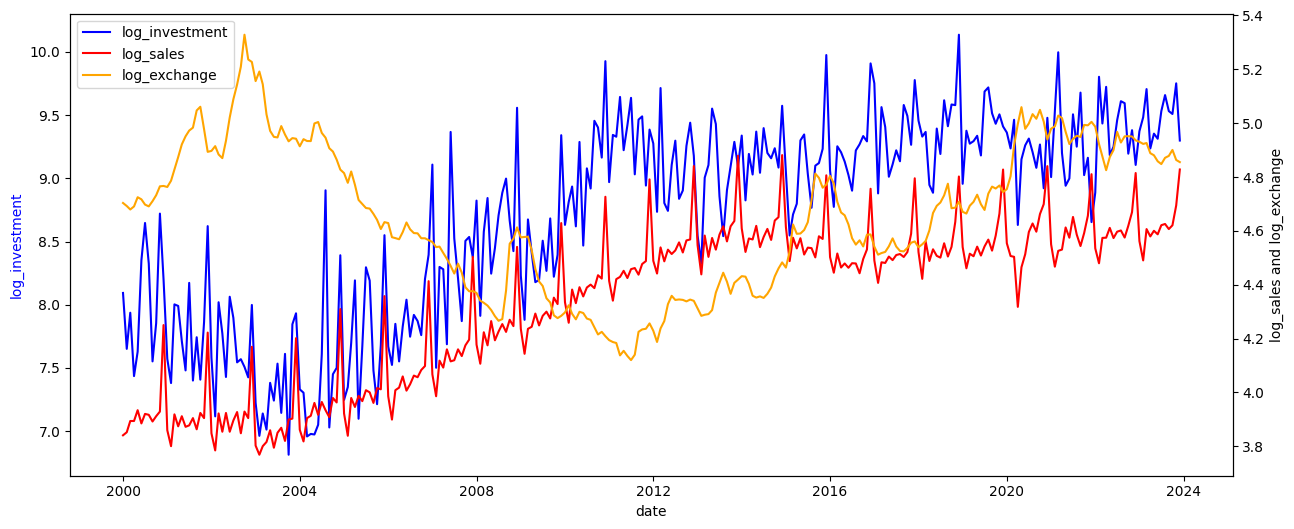

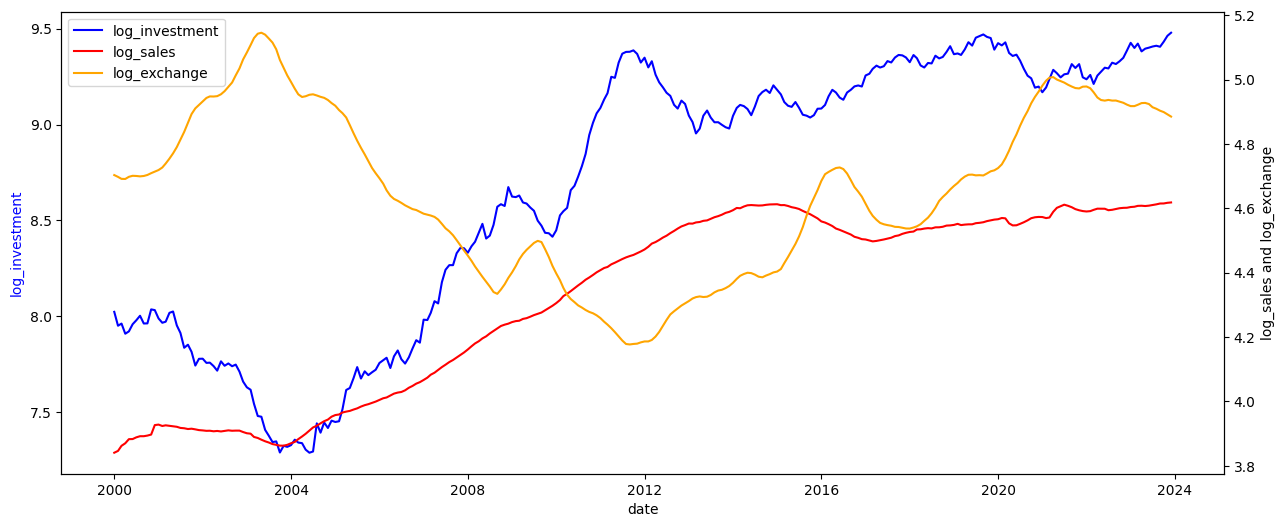

In [14]:
### Plot historical Values
# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot data on primary y-axis
ax1.plot(dates, log_investment, color='blue', label='log_investment')
ax1.set_xlabel('date')
ax1.set_ylabel('log_investment', color='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot additional data on the second y-axis
ax2.plot(dates, log_sales, color='red', label='log_sales')
ax2.plot(dates, log_exchange, color='orange', label='log_exchange')
ax2.set_ylabel('log_sales and log_exchange')

# Add legend for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


### Plot anual moving averages
# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot data on primary y-axis
ax1.plot(dates, investment_moving_average, color='blue', label='log_investment')
ax1.set_xlabel('date')
ax1.set_ylabel('log_investment', color='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot additional data on the second y-axis
ax2.plot(dates, sales_moving_average, color='red', label='log_sales')
ax2.plot(dates, exchange_moving_average, color='orange', label='log_exchange')
ax2.set_ylabel('log_sales and log_exchange')

# Add legend for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

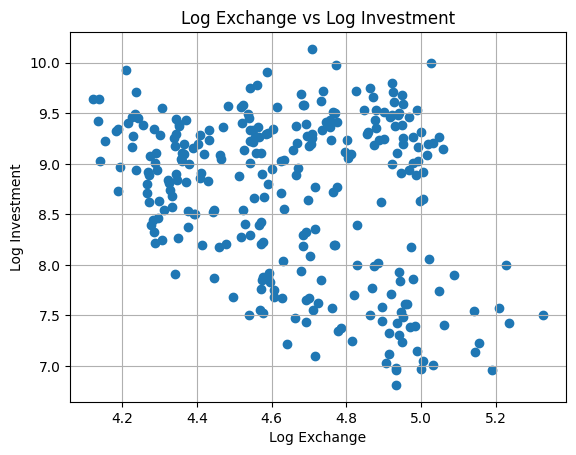

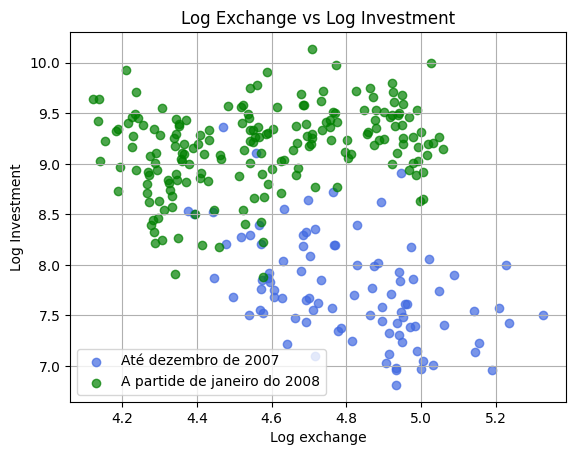

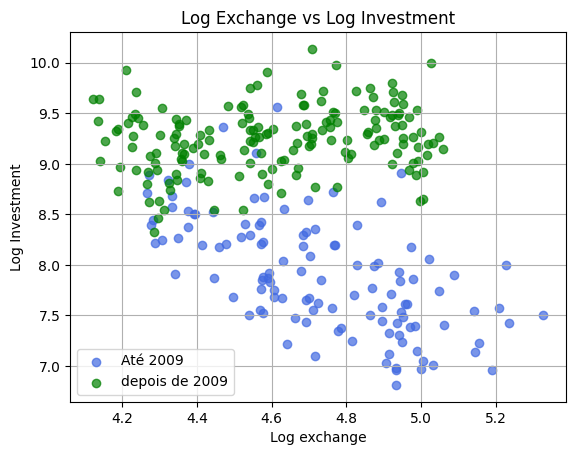

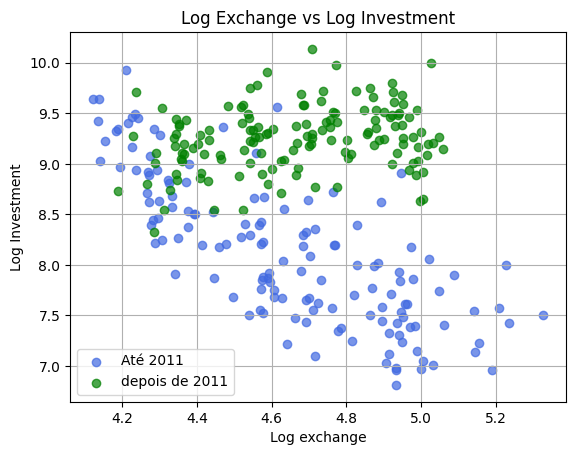

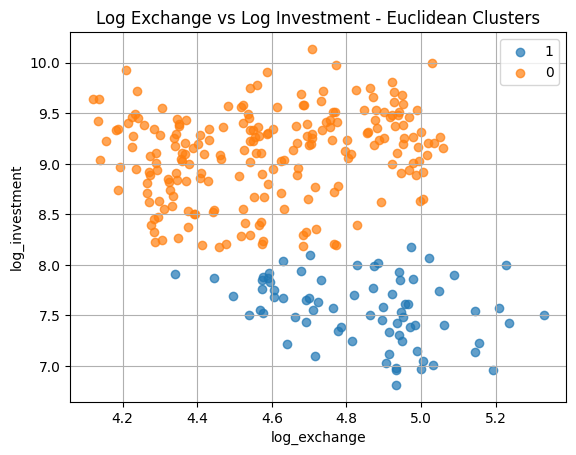

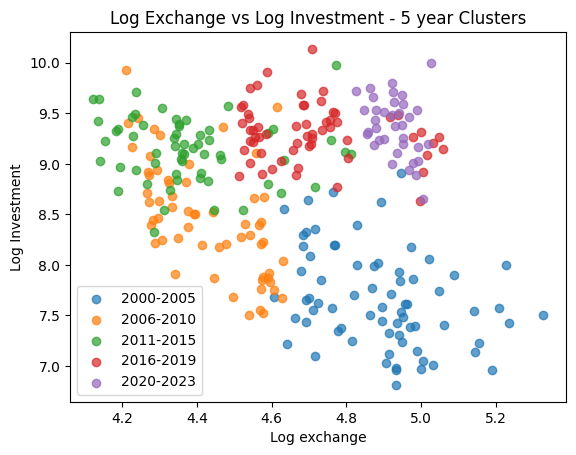

In [15]:
# # Plotting log_exchange against log_investment
plt.scatter(log_exchange, log_investment)
plt.xlabel('Log Exchange')
plt.ylabel('Log Investment')
plt.title('Log Exchange vs Log Investment')
plt.grid(True)
plt.show()

# # Plotting log_sales against log_investment
plt.scatter(log_exchange_up07, log_investment.iloc[:date_ref_07], color='royalblue', label='Até dezembro de 2007', alpha=0.7)
plt.scatter(log_exchange_after07, log_investment.iloc[date_ref_07plus1:], color='green', label='A partide de janeiro do 2008', alpha=0.7)
plt.xlabel('Log exchange')
plt.ylabel('Log Investment')
plt.title('Log Exchange vs Log Investment')
plt.legend()
plt.grid(True)
plt.show()

# # Plotting log_sales against log_investment
plt.scatter(log_exchange_up09, log_investment.iloc[:date_ref_09], color='royalblue', label='Até 2009', alpha=0.7)
plt.scatter(log_exchange_after12, log_investment.iloc[date_ref_09plus1:], color='green', label='depois de 2009', alpha=0.7)
plt.xlabel('Log exchange')
plt.ylabel('Log Investment')
plt.title('Log Exchange vs Log Investment')
plt.legend()
plt.grid(True)
plt.show()

# # Plotting log_sales against log_investment
plt.scatter(log_exchange_up11, log_investment.iloc[:date_ref_11], color='royalblue', label='Até 2011', alpha=0.7)
plt.scatter(log_exchange_after11, log_investment.iloc[date_ref_11plus1:], color='green', label='depois de 2011', alpha=0.7)
plt.xlabel('Log exchange')
plt.ylabel('Log Investment')
plt.title('Log Exchange vs Log Investment')
plt.legend()
plt.grid(True)
plt.show()

# # Plotting euclidean clusters
fig = plt.figure()
ax = fig.add_subplot()

for cluster in df['euclidean_exchange_clusters'].unique():
    clustered_data = df[df['euclidean_exchange_clusters'] == cluster]
    ax.scatter(
        x=clustered_data['log_exchange'],
        y=clustered_data['log_investment'],
        label=f'{cluster}',
        alpha=0.7
    )
ax.set_title('Log Exchange vs Log Investment - Euclidean Clusters')
ax.set_xlabel('log_exchange')
ax.set_ylabel('log_investment')
plt.legend()
plt.grid(True)
plt.show()


# # Plotting 5 year clusters
fig = plt.figure()
ax = fig.add_subplot()

for cluster in df['5_year_clusters'].unique():
    clustered_data = df[df['5_year_clusters'] == cluster]
    ax.scatter(
        x=clustered_data['log_exchange'],
        y=clustered_data['log_investment'],
        label=f'{cluster}',
        alpha=0.7
    )
ax.set_title('Log Exchange vs Log Investment - 5 year Clusters')
ax.set_xlabel('Log exchange')
ax.set_ylabel('Log Investment')

plt.legend()
# plt.grid(True)
plt.show()

# Chow Test comprehensive application

> ### Executes the Chow Test in december-january in every possible yearly span of data. ADF test is also executed for variables.

> eg: between the years of 2000 to 2003 have the following scenarios:
> 1.   2000-2001; one possible test
2.   2000-2002; two possible test
3.   2000-2003; three possible test
4.   2001-2002; one possible test
5.   2001-2003; two possible test
6.   2002-2003; one possible test

In [16]:
# Create an empty list to be transformed in DataFrame later and other helping
# variables
chow_tests_df = []
years = year_index(df, "date", "year")["years"]
year_indexes = year_index(df, "date", "year")["indexes"]

### To test all the possibilities, we need to test for every combination of
### start year, end year and the years between those two, hence the three
### loops below
# Start the start and end year loops
for year_start in years:
  for year_end in years:
    # Makes sure there is no backwards year reading of data.
    if year_start < year_end and year_end != 2000 and year_start != 2023:

      # Loop for every slice year
      n_year = year_end - year_start
      rage_year = range(0,n_year,1)
      for year_slice in rage_year:

        # stores the necessary indexes
        year_slice_str = str(year_start + year_slice)
        year_start_str = str(year_start)
        year_end_str = str(year_end)
        start_index = year_indexes["first_months"][year_start_str]
        end_index = year_indexes["last_months"][year_end_str]

        # Create the DataFrame for this loop
        df_chow_test = df.iloc[start_index:end_index + 1,:]
        n_samples = df_chow_test.shape[0]

        # Runs the test and store the result
        chowtest_results = ChowTest(
                                    y=df_chow_test[['log_investment']],
                                    X=df_chow_test[['log_exchange']],
                                    last_index_in_model_1=year_indexes["last_months"][year_slice_str],
                                    first_index_in_model_2=year_indexes["next_months"][year_slice_str]
                                    )

        chowtest_statistic = chowtest_results[0]
        chowtest_pvalue = chowtest_results[1]

        # Runs the ADF Tests
        adf_test_investment_p_value = adfuller_test(df_chow_test['log_investment'], 'log_investment', print_results=False)["adf_p_value"]
        adf_test_exchange_p_value = adfuller_test(df_chow_test['log_exchange'], 'log_exchange', print_results=False)["adf_p_value"]
        adf_test_sales_p_value = adfuller_test(df_chow_test['log_sales'], 'log_sales', print_results=False)["adf_p_value"]

        adf_test_investment_statistic = adfuller_test(df_chow_test['log_investment'], 'log_investment', print_results=False)["adf_statistic"]
        adf_test_exchange_statistic = adfuller_test(df_chow_test['log_exchange'], 'log_exchange', print_results=False)["adf_statistic"]
        adf_test_sales_statistic = adfuller_test(df_chow_test['log_sales'], 'log_sales', print_results=False)["adf_statistic"]

        #Store the results into a list
        chow_tests_df.append([year_start,year_end,year_slice_str,n_samples
                              ,chowtest_statistic
                              ,chowtest_pvalue
                              ,adf_test_investment_p_value, adf_test_exchange_p_value, adf_test_sales_p_value
                              ,adf_test_investment_statistic, adf_test_exchange_statistic, adf_test_sales_statistic])

# Create a dataframe from all tests
chow_tests_df = pd.DataFrame(chow_tests_df, columns=['Start year','End year','Slice year (december)', 'Number of samples'
                                                      ,'Chow Test statistic'
                                                      ,'Chow Test p-value'
                                                      ,'ADF Test statistic - investment', 'ADF Test statistic - exchange', 'ADF Test statistic - sales'
                                                      ,'ADF Test p-value - investment', 'ADF Test p-value - exchange', 'ADF Test p-value - sales' ])

In [17]:
chow_tests_df

,Start year,End year,Slice year (december),Number of samples,Chow Test statistic,Chow Test p-value,ADF Test statistic - investment,ADF Test statistic - exchange,ADF Test statistic - sales,ADF Test p-value - investment,ADF Test p-value - exchange,ADF Test p-value - sales
0,2000,2001,2000,24,1.218301,0.316759,1.683704e-03,0.001804,4.629900e-03,-3.952015,-3.933185,-3.665216
1,2000,2002,2000,36,1.929577,0.161733,3.500535e-06,0.894172,1.581413e-06,-5.393192,-0.488858,-5.555878
2,2000,2002,2001,36,0.566058,0.573341,3.500535e-06,0.894172,1.581413e-06,-5.393192,-0.488858,-5.555878
3,2000,2003,2000,48,2.166193,0.126683,3.302411e-05,0.365426,2.061094e-07,-4.912150,-1.830504,-5.958935
4,2000,2003,2001,48,2.339466,0.108257,3.302411e-05,0.365426,2.061094e-07,-4.912150,-1.830504,-5.958935
...,...,...,...,...,...,...,...,...,...,...,...,...
2295,2020,2023,2022,48,0.905698,0.411663,4.107969e-07,0.940361,1.593034e-01,-5.824566,-0.184355,-2.340287
2296,2021,2022,2021,24,0.496133,0.616179,1.024642e-03,0.012483,1.054715e-01,-4.085174,-3.357826,-2.542507
2297,2021,2023,2021,36,0.733942,0.487919,2.144128e-05,0.367695,4.426804e-01,-5.007559,-1.825871,-1.677617
2298,2021,2023,2022,36,0.386738,0.682401,2.144128e-05,0.367695,4.426804e-01,-5.007559,-1.825871,-1.677617


In [18]:
# Tranform the df for better reading of ADF Tests
adf_subset = ['Start year', 'End year',
              'ADF Test statistic - investment', 'ADF Test p-value - investment',
              'ADF Test statistic - exchange', 'ADF Test p-value - exchange',
              'ADF Test statistic - sales', 'ADF Test p-value - sales']

chow_tests_df_adf = chow_tests_df.loc[:,adf_subset]
chow_tests_df_adf = chow_tests_df_adf.drop_duplicates(subset=adf_subset)
chow_tests_df_adf.reset_index(inplace=True)
chow_tests_df_adf.pop('index')
chow_tests_df_adf

,Start year,End year,ADF Test statistic - investment,ADF Test p-value - investment,ADF Test statistic - exchange,ADF Test p-value - exchange,ADF Test statistic - sales,ADF Test p-value - sales
0,2000,2001,1.683704e-03,-3.952015,0.001804,-3.933185,4.629900e-03,-3.665216
1,2000,2002,3.500535e-06,-5.393192,0.894172,-0.488858,1.581413e-06,-5.555878
2,2000,2003,3.302411e-05,-4.912150,0.365426,-1.830504,2.061094e-07,-5.958935
3,2000,2004,1.349465e-06,-5.587948,0.287879,-1.997026,9.853046e-01,0.514413
4,2000,2005,2.597573e-01,-2.062743,0.527590,-1.511953,9.457941e-01,-0.135422
...,...,...,...,...,...,...,...,...
271,2020,2022,3.447292e-04,-4.363146,0.792483,-0.886201,6.112987e-08,-6.191319
272,2020,2023,4.107969e-07,-5.824566,0.940361,-0.184355,1.593034e-01,-2.340287
273,2021,2022,1.024642e-03,-4.085174,0.012483,-3.357826,1.054715e-01,-2.542507
274,2021,2023,2.144128e-05,-5.007559,0.367695,-1.825871,4.426804e-01,-1.677617


In [19]:
### Creates 4 dfs from the comprehensive df, each considering only the chow
### tests from max spans of 3 years, 6 years, 10 years and all spans.
### Then, we take the mean p-value for every slice year.

# df consindering all tests made
chow_tests_df_average = chow_tests_df.groupby('Slice year (december)').agg({'Chow Test p-value': 'mean', 'Chow Test statistic': 'mean', 'Start year': 'count'}).reset_index()
chow_tests_df_average.rename(columns={'Start year': 'Number of tests'}, inplace=True)

# df consindering only the tests made on a span of 10 years
chow_tests_df_average_10year = chow_tests_df[chow_tests_df['End year'] - chow_tests_df['Start year'] < 11]
chow_tests_df_average_10year = chow_tests_df_average_10year.groupby('Slice year (december)').agg({'Chow Test p-value': 'mean', 'Chow Test statistic': 'mean', 'Start year': 'count'}).reset_index()
chow_tests_df_average_10year.rename(columns={'Start year': 'Number of tests'}, inplace=True)

# df consindering only the tests made on a span of 6 years
chow_tests_df_average_6year = chow_tests_df[chow_tests_df['End year'] - chow_tests_df['Start year'] < 7]
chow_tests_df_average_6year = chow_tests_df_average_6year.groupby('Slice year (december)').agg({'Chow Test p-value': 'mean', 'Chow Test statistic': 'mean', 'Start year': 'count'}).reset_index()
chow_tests_df_average_6year.rename(columns={'Start year': 'Number of tests'}, inplace=True)

# df consindering only the tests made on a span of 3 years
chow_tests_df_average_3year = chow_tests_df[chow_tests_df['End year'] - chow_tests_df['Start year'] < 4]
chow_tests_df_average_3year = chow_tests_df_average_3year.groupby('Slice year (december)').agg({'Chow Test p-value': 'mean', 'Chow Test statistic': 'mean', 'Start year': 'count'}).reset_index()
chow_tests_df_average_3year.rename(columns={'Start year': 'Number of tests'}, inplace=True)


In [20]:
chow_tests_df_average

,Slice year (december),Chow Test p-value,Chow Test statistic,Number of tests
0,2000,0.197645,1.981976,23
1,2001,0.232293,2.325347,44
2,2002,0.027002,7.205654,63
3,2003,0.151025,8.738042,80
4,2004,0.154672,17.413573,95
5,2005,0.179652,32.010491,108
6,2006,0.022265,59.316377,119
7,2007,0.024125,70.098476,128
8,2008,0.063784,65.725833,135
9,2009,0.001673,92.993792,140


In [21]:
chow_tests_df_average_10year

,Slice year (december),Chow Test p-value,Chow Test statistic,Number of tests
0,2000,0.192641,1.876501,10
1,2001,0.257946,1.641953,19
2,2002,0.006369,6.876631,27
3,2003,0.277860,2.725356,34
4,2004,0.339127,2.188777,40
5,2005,0.428248,1.983842,45
6,2006,0.054060,5.999019,49
7,2007,0.059377,6.944395,52
8,2008,0.159359,6.412817,54
9,2009,0.004257,16.374298,55


In [22]:
chow_tests_df_average_6year

,Slice year (december),Chow Test p-value,Chow Test statistic,Number of tests
0,2000,0.142096,2.219365,6
1,2001,0.263715,1.786343,11
2,2002,0.010741,5.576578,15
3,2003,0.422107,1.355402,18
4,2004,0.563273,0.756669,20
5,2005,0.683871,0.560352,21
6,2006,0.105229,3.382241,21
7,2007,0.131130,3.380207,21
8,2008,0.263875,3.463866,21
9,2009,0.009308,8.244226,21


In [23]:
chow_tests_df_average_3year

,Slice year (december),Chow Test p-value,Chow Test statistic,Number of tests
0,2000,0.201725,1.771357,3
1,2001,0.387061,1.257717,5
2,2002,0.018420,4.922068,6
3,2003,0.582682,0.743833,6
4,2004,0.645952,0.467852,6
5,2005,0.846518,0.178143,6
6,2006,0.199610,2.917656,6
7,2007,0.209180,3.554765,6
8,2008,0.270297,3.753831,6
9,2009,0.009955,6.140603,6


# **Ploting mean p-value from the comprehensive DF**
> Subsets max spans of 3 years, 6 years, 10 years and all spans.

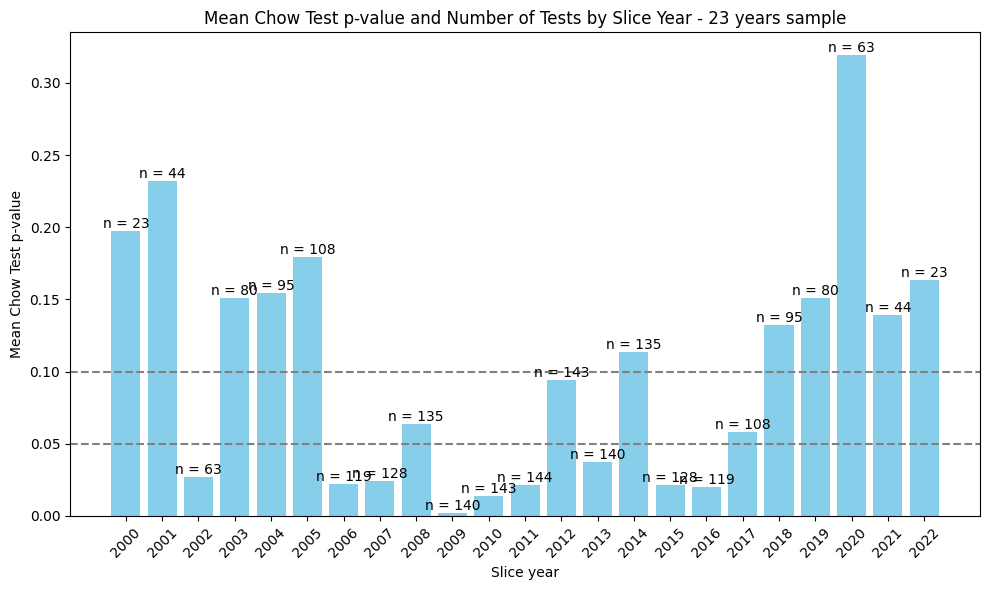

In [24]:
#### Ploting the average p-value with all tests made

testing_df = chow_tests_df_average

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(testing_df['Slice year (december)'], testing_df['Chow Test p-value'], color='skyblue')

# Add text labels for the sum of number of samples above each bar
for bar, samples in zip(bars, testing_df['Number of tests']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n = {samples}', ha='center', va='bottom', rotation=0)

# Set labels and title
ax.set_xlabel('Slice year')
ax.set_ylabel('Mean Chow Test p-value')
ax.set_title('Mean Chow Test p-value and Number of Tests by Slice Year - 23 years sample')

# Add dashed lines for Chow Test Chow Test p-value 0.05 and Chow Test p-value 0.10
ax.axhline(y=0.05, color='gray', linestyle='--', label='Chow Test p-value = 0.05')
ax.axhline(y=0.10, color='gray', linestyle='--', label='Chow Test p-value = 0.10')


# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

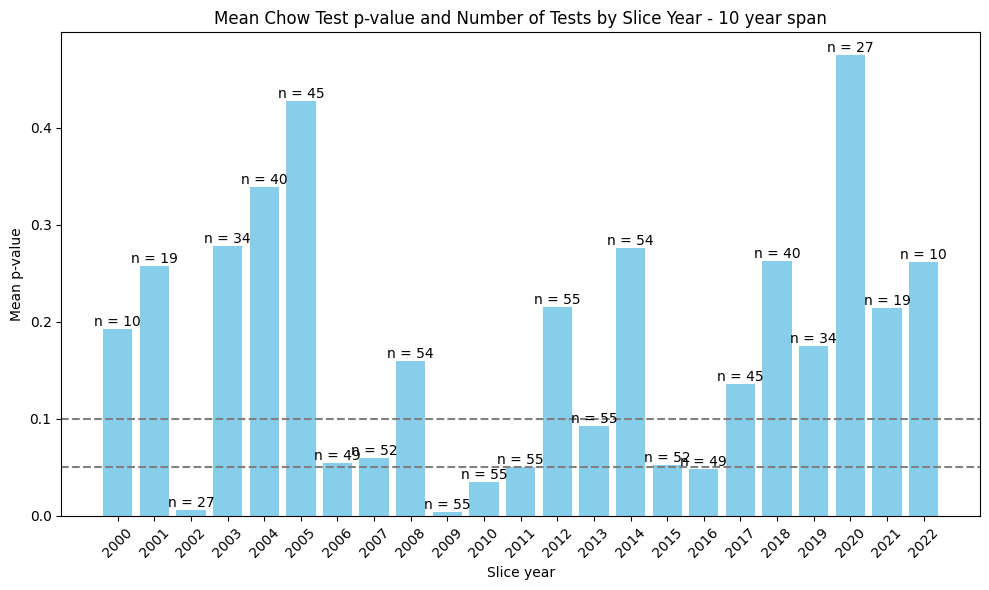

In [25]:
#### Ploting the average p-value with max 10 years spans
testing_df = chow_tests_df_average_10year

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(testing_df['Slice year (december)'], testing_df['Chow Test p-value'], color='skyblue')

# Add text labels for the sum of number of samples above each bar
for bar, samples in zip(bars, testing_df['Number of tests']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n = {samples}', ha='center', va='bottom', rotation=0)

# Set labels and title
ax.set_xlabel('Slice year')
ax.set_ylabel('Mean p-value')
ax.set_title('Mean Chow Test p-value and Number of Tests by Slice Year - 10 year span')

# Add dashed lines for Chow Test p-value 0.05 and Chow Test p-value 0.10
ax.axhline(y=0.05, color='gray', linestyle='--', label='Chow Test p-value = 0.05')
ax.axhline(y=0.10, color='gray', linestyle='--', label='Chow Test p-value = 0.10')

# Show the legend
# ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

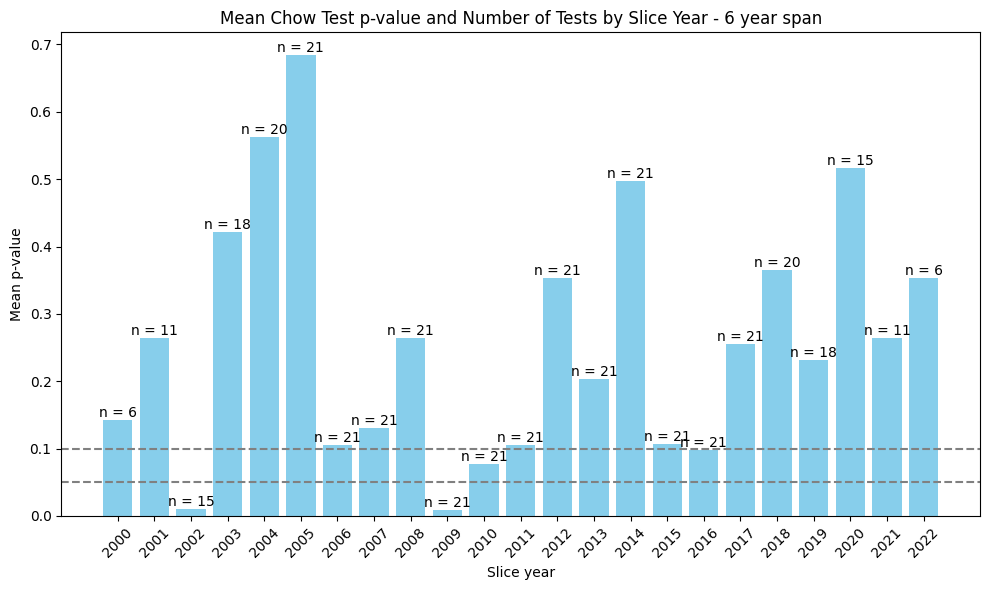

In [26]:
#### Ploting the average p-value with max 6 years spans
testing_df = chow_tests_df_average_6year

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(testing_df['Slice year (december)'], testing_df['Chow Test p-value'], color='skyblue')

# Add text labels for the sum of number of samples above each bar
for bar, samples in zip(bars, testing_df['Number of tests']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n = {samples}', ha='center', va='bottom', rotation=0)

# Set labels and title
ax.set_xlabel('Slice year')
ax.set_ylabel('Mean p-value')
ax.set_title('Mean Chow Test p-value and Number of Tests by Slice Year - 6 year span')

# Add dashed lines for Chow Test p-value 0.05 and Chow Test p-value 0.10
ax.axhline(y=0.05, color='gray', linestyle='--', label='Chow Test p-value = 0.05')
ax.axhline(y=0.10, color='gray', linestyle='--', label='Chow Test p-value = 0.10')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

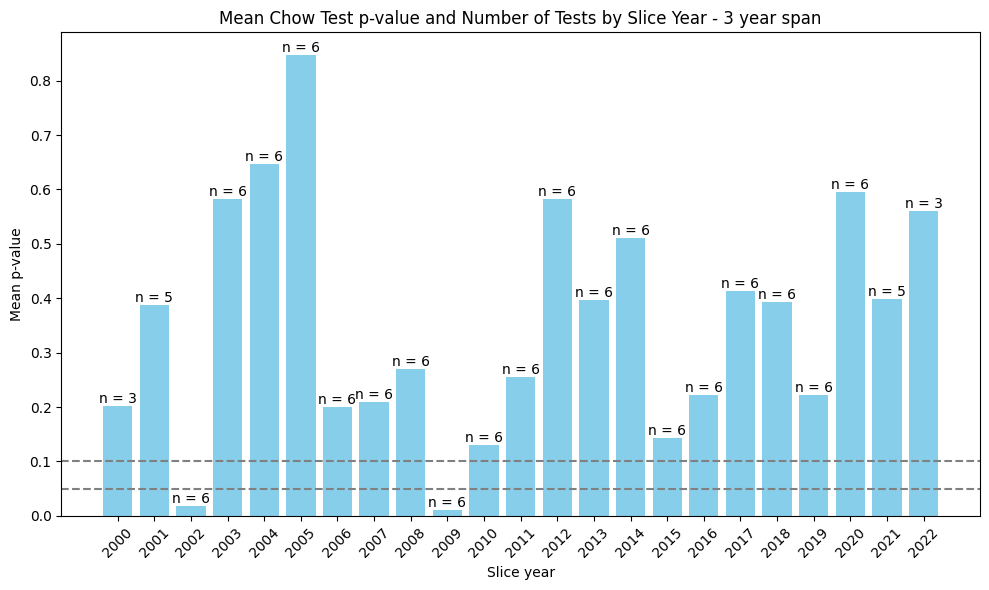

In [27]:
#### Ploting the average p-value with max 3 years spans
testing_df = chow_tests_df_average_3year

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(testing_df['Slice year (december)'], testing_df['Chow Test p-value'], color='skyblue')

# Add text labels for the sum of number of samples above each bar
for bar, samples in zip(bars, testing_df['Number of tests']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n = {samples}', ha='center', va='bottom', rotation=0)

# Set labels and title
ax.set_xlabel('Slice year')
ax.set_ylabel('Mean p-value')
ax.set_title('Mean Chow Test p-value and Number of Tests by Slice Year - 3 year span')

# Add dashed lines for Chow Test p-value 0.05 and Chow Test p-value 0.10
ax.axhline(y=0.05, color='gray', linestyle='--', label='Chow Test p-value = 0.05')
ax.axhline(y=0.10, color='gray', linestyle='--', label='Chow Test p-value = 0.10')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()